# Predict rain based on other weather variables

This notebook will use time lags to train a machine learning model for predicting rain (precipitation). 

First, we select a random station. The data is kept at daily resolution. Then, we generate a lagged feature matrix.

In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
%%time
data_dir = './datasets/NOAA_SST/'
#load(data_dir + “noaa_gsod/…/file”
t0 = time.time()
data = pd.read_pickle(data_dir+'noaa_gsod/Combined_noaa_gsod') # load weather data
stations = pd.read_pickle(data_dir+'noaa_gsod.stations') # load station data

# # USE ONLY 2008-2018 # #
data = data.loc[data.index >= pd.Timestamp(2008, 1, 1)]
data = data.drop(columns=['yr','year','da','mo']) # don't need these anymore
print(time.time()-t0)

15.130345106124878
Wall time: 15.1 s


In [5]:
# # SELECT RANDOM STATION # #
np.random.seed(3)
rs = np.unique(data['stn'].values) # find unique stations with data
rand_stat = rs[randint(len(rs))] # pick a random station

# # ideally we should check < len(np.unique(data.index)), but many are shorter
while (len(data.loc[data['stn'] == rand_stat]) < 3650): # If not enough data
    if len(stations.loc[stations['usaf'] == rand_stat]): # If station info available
        if (stations.loc[stations['usaf'] == rand_stat].iloc[0]['wban'] != '99999'): # If station number not unique
            rand_stat = rs[randint(len(rs))] # get a new station
    else:
        rand_stat = rs[randint(len(rs))] # get a new station

select_station = stations.loc[stations['usaf'] == rand_stat] # get location, etc, for random station

features = data.loc[data['stn'] == rand_stat] # pick weather at random station
features = features.drop(columns='stn')
features = features.sort_index()
select_station.head() # see where it is

,usaf,wban,name,country,state,call,lat,lon,elev,begin,end
5946,712220,99999,DEASE LAKE (AUT),CA,None,CWKX,58.433,-130.033,+0802.0,19930829,20190326


In [6]:
features.shape

(3929, 7)

### Time-shift the data

In [7]:
columns = features.columns # weather variables
for co in columns:
    # one day lag
    features[co + '_lag1'] = features[co].shift(periods=1)
    
    # two days lag
    features[co + '_lag2'] = features[co].shift(periods=2)
    
    # three days lag
    features[co + '_lag3'] = features[co].shift(periods=3)
features = features.iloc[3:]
print(str(len(features)) + ' samples, ' + str(len(features.columns)) + ' features.')
features.head()

3926 samples, 28 features.


,temp,slp,wdsp,mxpsd,max,min,prcp,temp_lag1,temp_lag2,temp_lag3,...,mxpsd_lag3,max_lag1,max_lag2,max_lag3,min_lag1,min_lag2,min_lag3,prcp_lag1,prcp_lag2,prcp_lag3
Datetime,,,,,,,,,,,,,,,,,,,,,
2008-01-04,9.5,982.6,2.4,5.8,12.7,2.5,0.08,5.5,0.0,-1.7,...,4.9,10.4,10.4,10.4,3.2,-7.6,-13.2,0.00,0.00,0.00
2008-01-05,6.6,978.9,2.2,4.9,15.8,-2.2,0.03,9.5,5.5,0.0,...,7.0,12.7,10.4,10.4,2.5,3.2,-7.6,0.08,0.00,0.00
2008-01-06,11.4,987.0,2.8,5.8,15.8,0.7,0.12,6.6,9.5,5.5,...,7.0,15.8,12.7,10.4,-2.2,2.5,3.2,0.03,0.08,0.00
2008-01-07,-7.3,1005.2,3.7,7.0,13.3,-15.2,0.00,11.4,6.6,9.5,...,5.8,15.8,15.8,12.7,0.7,-2.2,2.5,0.12,0.03,0.08
2008-01-08,-8.9,1005.8,5.3,9.9,-3.5,-15.2,0.00,-7.3,11.4,6.6,...,4.9,13.3,15.8,15.8,-15.2,0.7,-2.2,0.00,0.12,0.03


### Create train/val/test

In [8]:
ylabel = features['prcp'] # use today's precipitation as the label
features = features.drop(columns='prcp') # don't put it in training data!!

# Use 20% test split (80% training + validation)
ntrain = int(len(features)*0.8)
x_test = features.iloc[ntrain:,:]
y_test = ylabel[ntrain:]
indices = np.arange(ntrain)


# Split remaining 80% into training-validation sets by 60%/20% (of original data)
x_train, x_val, y_train, y_val, idx1, idx2 = train_test_split(features.iloc[0:ntrain,:], ylabel[0:ntrain], \
                                                   indices, test_size=0.2, random_state=1)

# # Scale features. Fit scaler on training only.
scaler = MinMaxScaler() #scale features between 0 and 1
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

### Predict with Random Forest

In [9]:
int(len(features)*.8)

3140

In [10]:
# # Create, train, and predict random forest here # #





### Plot random forest

NameError: name 'y' is not defined

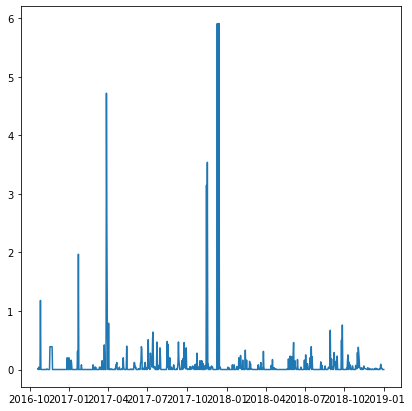

In [11]:
# plot predictions
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.plot(features.iloc[ntrain:].index, y_test) # plot actual precipitation
plt.plot(features.iloc[ntrain:].index, y) # plot predicted precipitation, y is the prediction results on testing data


# # PLOT TRAINING DATA HERE # #





# # INCREASE X TICK SPACING, UPDATE LEGEND # #
plt.xticks(features.index[::182], rotation = 45) # X-Ticks are spaced once every 30 days. 
myFmt = mdates.DateFormatter('%b-%y') # This shows day-month-year. Switch to month-year or annually

plt.gca().xaxis.set_major_formatter(myFmt)
plt.ylabel('Daily Precipitation (inches)', fontsize=12)
plt.legend(('Test Label','Test Prediction','Train Label','Train Prediction'), fontsize=12, loc=1)
#plt.show()

# # Plot the feature importances # #
nfeatures = 10
fi = regr.feature_importances_ # get feature importances, regr is the regressor
fi_sort = np.argsort(fi)[::-1] # sort importances most to least
plt.subplot(1,2,2)
plt.bar(range(nfeatures), fi[fi_sort[0:nfeatures]], width=1, \
        tick_label=features.columns.values[fi_sort[0:nfeatures]]) # plot features importances
plt.ylabel('Feature Importance (avg across trees)', fontsize=12)
plt.xticks(rotation = 45)
plt.show()

### Feature importance is the weighted impurity of a branch adjusted by its children nodes and normalized by the impurities of all branches. The Random Forest feature importances are averaged over all regression trees.